In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Create data from power spectrum

This function is set up to create a single Lorentzian peak and will be used to create several "modes". The mode height and central frequency will be set by the factor $i$ relative to the other input parameters. The mode height will be reduced by a factor $i^2$, and the central freuqency will be shifted by a factor $i$.

In [2]:
def single_lorentzian(x, x_0, A, width, i):
    model = ((2*A**2 / (np.pi*width*i**2)) / (1 + (2*(x-i*x_0) / width)**2))
    return model

Here we create and plot the power spectrum of the artificial data, to have a peak at the 27-rotation period ($\nu_0$) with 4 harmonics $n \, \nu_0$ for n in range 2-5.

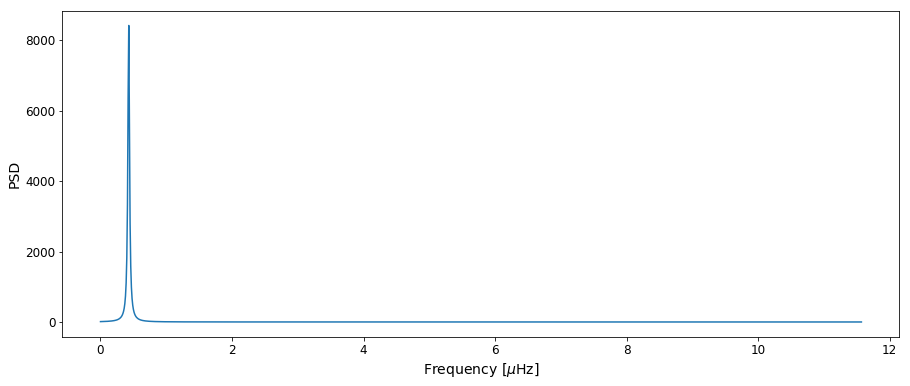

Peak at nu_0 = 0.43 muHz


In [6]:
x = np.arange(0, (1*1e6/(3600*24)), 0.01) # Nyquist = 1 day / Resolution 0.01 muHz (~ 3 yrs)
x_0 = (1e6/(3600*24*27)) # Central frequency of fundamental peak
A = 20 # Amplitude of fundamental peak
width = 0.03 # Width

powers = [single_lorentzian(x, x_0, A, width, i) for i in np.arange(1,2)] # Create 5 peaks
powers = np.sum(powers, axis=0) # Sum single peaks together into one power spectrum,=
powers = powers + 1 # Add a backgnd level of 1

# Plot peaks
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(x, powers)
plt.show()

print("Peak at nu_0 = %s muHz"%x[np.argmax(powers)])

Now we need to convert the signal from PSD into amplitude ($A(f(k))$): $A(f(k)) \, = \, \sqrt{2 \,\mathrm{PSD}}$

Then to convert from amplitude to the frequency domain signal ($Z(f(k))$): $Z(f(k)) \, = \, A(f(k)) \, e^{i \phi(f(k)))}$, where $\phi(f(k))$ is some random phase supplied to the signal between $0$ and $2\pi$.

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


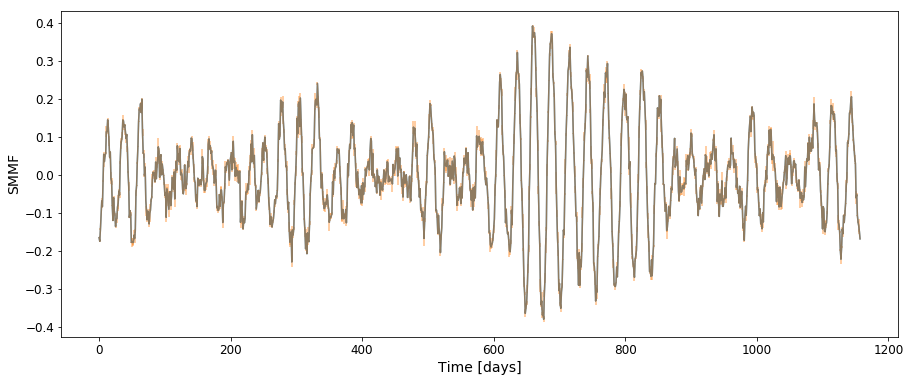

Time-series real component variance: 0.01510185230722864


In [7]:
amplitudes = np.sqrt(powers) # Compute amplitudes from powers
phases = np.random.uniform(0, 2*np.pi, len(amplitudes)) # Generate random phases
freq_sigs = [a*np.exp(1j*p) for a,p in zip (amplitudes, phases)] # Conversion to frequency domain signal
time_series = np.fft.ifft(freq_sigs)
t = np.arange(len(time_series))

# Plot time-series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(t, time_series)

yerr = np.random.normal(0, 0.01, len(time_series))
ax.errorbar(t, time_series, abs(yerr), alpha=0.5)
plt.show()

# Put the timeseries into a pandas DataFram with the index as time since 01/01/1992
df = pd.DataFrame({'SMMF':time_series.real}, index=[datetime.datetime(1992,1,1) + datetime.timedelta(days=int(ti)) for ti in t])

print('Time-series real component variance: %s'%(np.std(time_series.real)**2))

Now we should re-do the FFT to ensure that the PSD comes out the same as what we started with.

Begin FFT...
Pre-mask times length: 1158
Fill is: 1.0
Post-mask times length: 1158
TS_var: 0.01510185230722864
FD: 0.01516260277053925


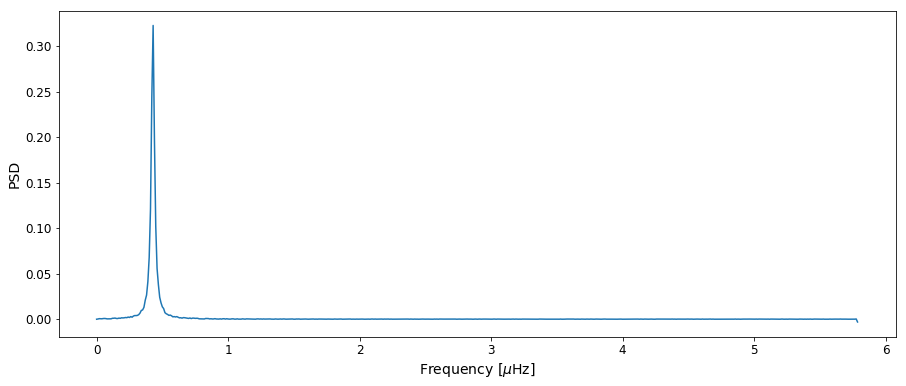

Time-series variance: 0.01510185230722864
Peak at nu_0 = 0.4297799526642359 muHz


In [8]:
import timeseries_FFT

def FFT(start, end, data = None, oversample = False, plot=False):
    print('Begin FFT...')
    # data = self.Vn_df[0] # set FFT data
    data = data
    error = data*0.0001

    f = timeseries_FFT.timeseries_FFT_plot(data, error, start, end, 'SMMF [G]', 'PSD [$G^2$$\mu$Hz$^{-1}$]', maj_tick = .5, min_tick=.05)
    freqs, power, times = f.FT_data()
    if plot == True:
        f.make_plot()
    return freqs, power, times

# Re-compute the power spectrum
freqs, power, times = FFT(start = pd.to_datetime(df.index.values[0]), end = pd.to_datetime(df.index.values[-1]), data = df['SMMF'], plot=False, oversample=False)

# Plot power re-calculated power spectrum
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(freqs, power)
plt.show()

print('Time-series variance: %s'%(np.std(df['SMMF'])**2))
print("Peak at nu_0 = %s muHz"%freqs[np.argmax(power)])

This looks ok... the y-axis values are different to those used during the input which should be checked... it could be a mixture of units/mistakes in going from PSD->AMP->TS/general errors that have caused this difference.

The new nyquist is half the original due to the way that I set up the frequency grid to be $\frac{1}{2 dT}$, whdre $dT$ is the sampling in the time domain.

## Celerite model

Now we will try to model the time-series using a GP.

In [9]:
import celerite
from celerite import terms
from celerite.modeling import Model

# Set bounds
bounds = dict(log_a=(-5, 10), log_c=(-10, 5))

# Define the kernel
kernel = terms.RealTerm(log_a=np.log(np.var(df['SMMF'].values)), log_c=-np.log(10.0), bounds=bounds)

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "P")

    def get_value(self, t):
        return self.A * np.sin(2.0 * np.pi * t / self.P)

model = MeanModel(0.02, 10)
    
# Create and compute GP
gp = celerite.GP(kernel, mean=model, fit_mean=True)
gp.compute(t, yerr)  # Always need to call compute once
print("Initial log likelihood: %.6f"%(gp.log_likelihood(df['SMMF'].values)))
print(gp.get_parameter_vector())

Initial log likelihood: 1962.072396
[-4.19293787 -2.30258509  0.02       10.        ]


Create likelihood function for emcee to work with

In [8]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    if params[2] < 0:
        return -np.inf
    return gp.log_likelihood(df['SMMF'].values) + lp

Run emcee on this

In [9]:
import emcee

initial = gp.get_parameter_vector()
print(initial)
ndim, nwalkers = len(initial), 100
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 4000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 4000);

print("We're done here...")

[-4.18872838 -2.30258509  0.02       10.        ]
Running burn-in...
Running production...
We're done here...


Import and plot corner

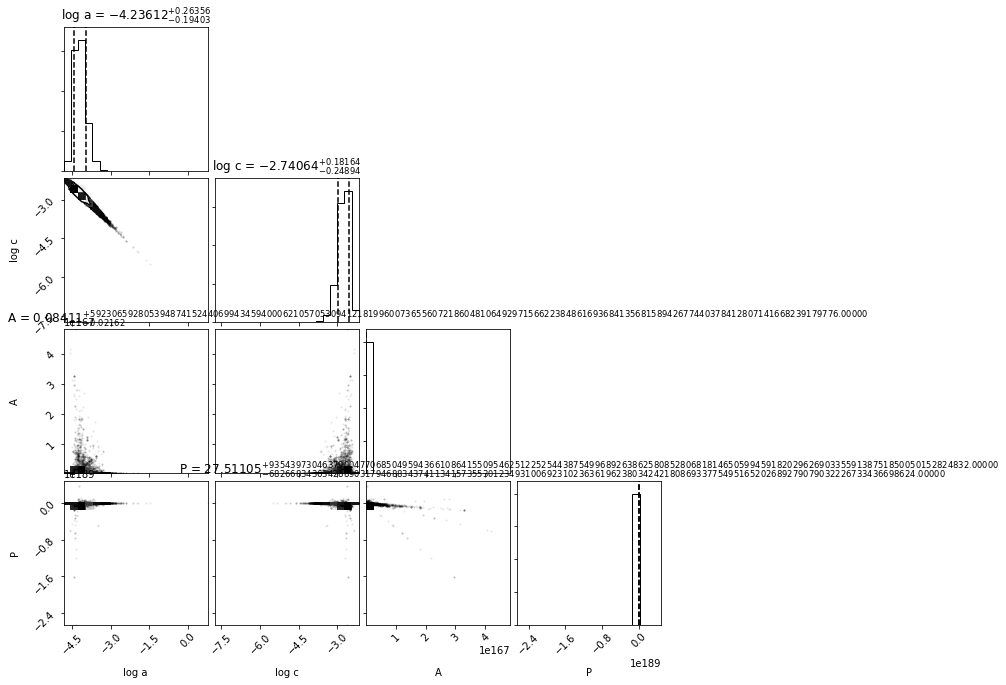

In [10]:
import corner
corner.corner(sampler.flatchain, labels=['log a', 'log c', 'A', 'P'], 
              show_titles = True, 
              quantiles = [0.5-0.3413, 0.5+0.3413], 
              title_fmt='.5f')
plt.show()

-27.01559906497842
0.019505318810281624


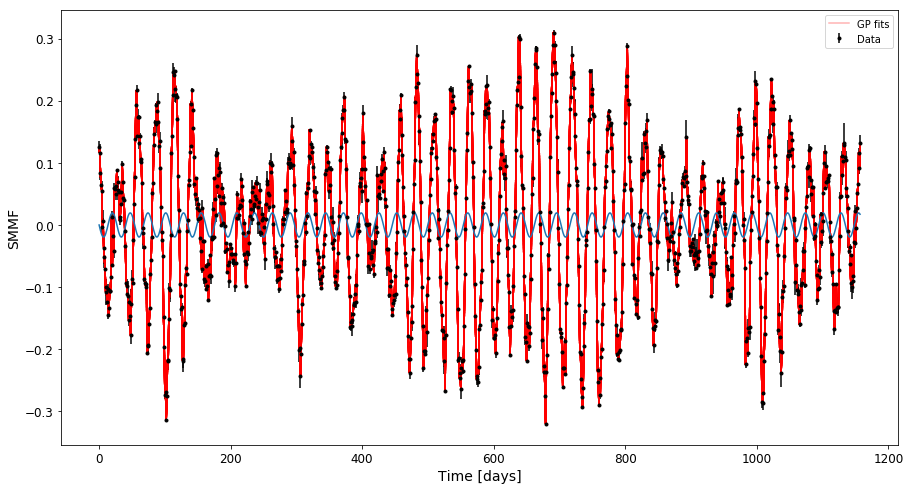

In [11]:
# Plot the data.
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)

ax.errorbar(t, df['SMMF'].values, yerr=yerr, fmt=".k", capsize=0, label='Data')

#lp = like(t, df['SMMF'].values, yerr)
# Plot GP samples.
samples = sampler.flatchain
itn = 0
for s in samples[np.random.randint(len(samples), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(df['SMMF'].values, t, return_cov=False)
    if itn == 0:
        a = ax.plot(t, mu, color='r', alpha=0.3, label='GP fits')
        itn+=1
    else:
        a = ax.plot(t, mu, color='r', alpha=0.3)

ax.legend()

ax.plot(t, model.get_value(t))
print(model.P)
print(model.A)